In [2]:

from scipy.stats.qmc import LatinHypercube as LHSampler
from scipy.stats import qmc 
from scipy.integrate import quad, dblquad, tplquad, nquad
from matplotlib import cm, pyplot as plt
import numpy as np
from src.utils import *
# from src.eLHS_old import *
import json
from math import floor, ceil
from src.fancyplotter import usePlotSampleSet, SampleSetPlot
from typing import Callable, Generator
from latinexpansion import grade, eLHS
import ipywidgets as ws 
from time import time
from IPython.display import clear_output

LHS = LHSampler(d = 2)
err = 1e-9


# EXPERIMENT III

In [77]:
# from https://en.wikipedia.org/wiki/Monte_Carlo_integration#Python_example
throws = 20000
inside_circle = 0
i = 0
radius = 1
while i < throws:
    # Choose random X and Y centered around 0,0
    x = np.random.uniform(-radius, radius)
    y = np.random.uniform(-radius, radius)
    # If the point is inside circle, increase variable
    if x**2 + y**2 <= radius**2:
        inside_circle += 1
    i += 1

# Calculate area and print; should be closer to Pi with increasing number of throws
area = (((2 * radius) ** 2) * inside_circle) / throws
print(area)

3.135


## Monte Carlo Simulation

### MCSim 2-D with Sobol and LHS

In [123]:
def l(x, y, z):
    return x**2 * y + y**2 * z + z**2 * x

def g(x, y, z):
    return np.exp(-x**2 - y**2 - z**2) * np.sin(x) * np.cos(y) * np.sin(z)

def h(x, y, z):
    return (x**2 + y**2 + z**2) / ((1 + x**2) * (1 + y**2) * (1 + z**2))

def k(x, y, z):
    return (x * np.sin(y) + y * np.cos(z) + z * np.sin(x)) * (x + y**2 + z**3)

# Define the integration bounds
bounds_x = [0, 2]
bounds_y = [0, 2]
bounds_z = [0, 2]
l_bounds = [bounds_x[0], bounds_y[0], bounds_z[0]]
u_bounds = [bounds_x[1], bounds_y[1], bounds_z[1]]

V = (bounds_x[1] - bounds_x[0]) * (bounds_y[1] - bounds_y[0]) * (bounds_y[1] - bounds_y[0])

# Integrate the functions over the specified bounds
integral_l, _ = nquad(l, [bounds_z, bounds_y, bounds_x])
integral_g, _ = nquad(g, [bounds_z, bounds_y, bounds_x])
integral_h, _ = nquad(h, [bounds_z, bounds_y, bounds_x])
integral_k, _ = nquad(k, [bounds_z, bounds_y, bounds_x])

In [155]:

Nstart, Nmax, step, iter = 100, 10000, 50, 20
ns = np.arange(Nstart, Nmax, step)

def fun(v):
    x, y, z = v
    return l(x, y, z)

lhs_agent = LHSampler(d=3)
def elhs_agent(S, M):
    if M == 0: 
        return S
    else:
        return concat(S, eLHS(S, M))

initial_Ss = [lhs_agent.random(Nstart) for _ in range(iter)]
perfres = integral_l

exp3data = np.zeros((len(ns), 3), dtype=object)

for i in range(len(ns)):
    labor = np.zeros((iter, 2))
    for j in range(iter):
        xslhs = lhs_agent.random(ns[i])
        xslhs = qmc.scale(xslhs, l_bounds, u_bounds)
        xselhs = elhs_agent(initial_Ss[j], ns[i] - Nstart)
        xselhs = qmc.scale(xselhs, l_bounds, u_bounds)
        labor[j, 0] = MCSim(fun, xslhs, V)
        labor[j, 1] = MCSim(fun, xselhs, V)
    exp3data[i] = [ns[i], labor[:, 0], labor[:, 1]]
    

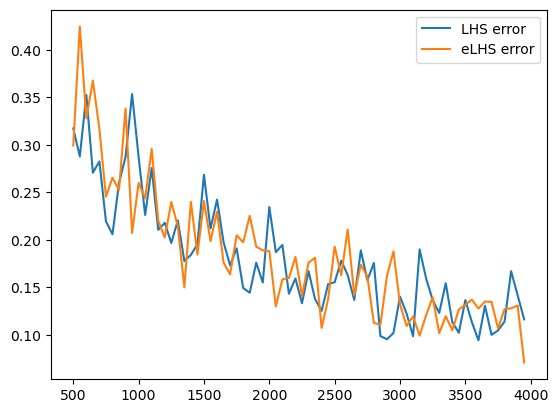

In [146]:

accrate = np.zeros((len(ns), 3))
tmpdata = np.zeros((len(ns), 3),dtype=object)

def moving_average(data, window_size = 2):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

for i in range(len(ns)):
    accrate[i] = [exp3data[i][0], 
                  np.average(np.abs(perfres - exp3data[i][1])), 
                  np.average(np.abs(perfres - exp3data[i][2]))]
plt.plot(accrate[:,0], accrate[:,1], label="LHS error")
plt.plot(accrate[:,0], accrate[:,2], label="eLHS error")
plt.legend()
plt.show()

### MCSim LHS vs eLHS

In [ ]:

perfres = dblquad(lambda *x: fun3(x), 0, 1, 0, 1)[0]

Nstart, Nmax, step, iter = 100, 2000, 50, 10
ns = np.arange(Nstart, Nmax, step)
accrate = np.zeros((len(ns), 3))

sobol_sampler = qmc.Sobol(2)
for i in range(len(ns)):
    avgsum = np.zeros((iter, 2))
    for j in range(iter):
        xslhs = LHS.random(ns[i])
        xssobol = sobol_sampler.random(ns[i])
        avgsum[j, 0] = MCSim(fun3, xslhs, 1)
        avgsum[j, 1] = MCSim(fun3, xssobol, 1)
    lhsavg = np.sum(np.abs(perfres - avgsum[:, 0]))/iter
    sobolavg = np.sum(np.abs(perfres - avgsum[:, 1]))/iter
    accrate[i] = [ns[i], lhsavg, sobolavg]
    
plt.plot(accrate[:, 0], accrate[:, 1])
plt.plot(accrate[:, 0], accrate[:, 2])
plt.show()

# EXPERIMENT I 
## Grade Evolution

In [250]:
N, P = 500, 2
exp1ss = LHSampler(d=P).random(N)

In [251]:

K = 3  # M ranges from N to K*N
ms = np.array((range(0, K*N + 1)), dtype=int)
ys = np.vectorize(lambda M: grade(exp1ss, M) + M/(N+M))(ms)


In [489]:
# data = np.column_stack((ms, ys)).tolist()
# expsave(
#     "exp1.grade_evol", 
#     {
#         "S": exp1ss.tolist(), "data": data, 
#         "N": N, "P": P, 
#         "Mmin": 0, "Mmax": K*N,
#         "DESCRIPTION": "medium"
#     },
#     "a", 
#     description="grade of the expansion of S in function of M. An easy, medium and difficult computation are proposed.")

In [477]:
# dumped_data = expget("exp1.grade_evol")["datalist"][0]
# data = np.array(dumped_data["data"])
# ms, ys = data[:, 0], data[:, 1]
# N, P = dumped_data["N"], dumped_data["P"] 
# exp1ss = np.array(dumped_data["S"])

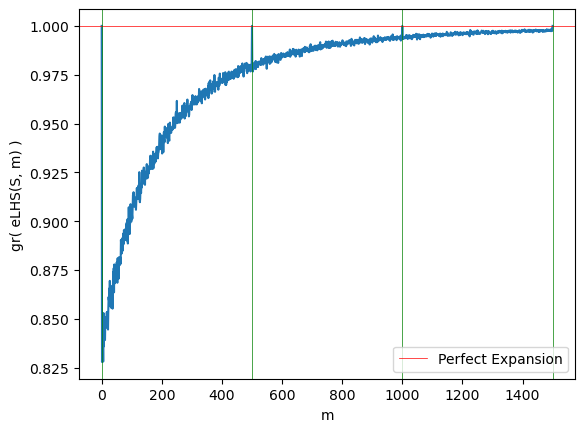

In [252]:
plt.plot(ms, ys)
plt.xlabel("m")
plt.ylabel("gr( eLHS(S, m) )")
plt.axhline(1.0, color='red', linestyle='-', linewidth = 0.5, label = "Perfect Expansion")
for K in range(0, K + 1):
    plt.axvline(K * N, color='green', linestyle='-', linewidth = 0.5)
plt.legend()
# plt.savefig("./data/plots/strat_evol.N_" + str(N) + ".P_" + str(P) + ".png")
plt.show()

# EXPERIMENT I v3

### multiple agents and other's method comparisons 

In [225]:
N, P = 500, 5
agents = 10
exp1_3lhs_agents = [ LHSampler(d=P).random(N) for _ in range(agents)]
exp1_3lhs_agents = [ qmc.Sobol(d=P).random(N) for _ in range(agents)]

In [ ]:

K = 3  # M ranges from N to K*N
ms = np.array((range(0, K*N + 1)), dtype=int)
ys = np.vectorize(lambda M: grade(exp1ss, M) + M/(N+M))(ms)


In [ ]:
data = np.column_stack((ms, ys)).tolist()
expsave(
    "exp1.grade_evol", 
    {
        "S": exp1ss.tolist(), "data": data, 
        "N": N, "P": P, 
        "Mmin": 0, "Mmax": K*N,
        "DESCRIPTION": "medium"
    },
    "a", 
    description="grade of the expansion of S in function of M. An easy, medium and difficult computation are proposed.")

In [ ]:
plt.plot(ms, ys)
plt.xlabel("m")
plt.ylabel("gr( eLHS(S, m) )")
plt.axhline(1.0, color='red', linestyle='-', linewidth = 0.5, label = "Perfect Expansion")
for K in range(0, K + 1):
    plt.axvline(K * N, color='green', linestyle='-', linewidth = 0.5)
plt.legend()
# plt.savefig("./data/plots/strat_evol.N_" + str(N) + ".P_" + str(P) + ".png")
plt.show()

# EXPERIMENT 1 v2
### involving P axes and multiple agents

In [4]:
N = 200
Pmin, Pmax = 2, 50
n_agents = 5

exp2agents = [
    [LHSampler(d=p).random(N).tolist() for _ in range(n_agents)] 
        for p in range(Pmin, Pmax+1)
]

In [8]:
K = 3  # M ranges from N to K*N
ms = np.array(range(0, K*N + 1), dtype=int)
ps = list(range(Pmin, Pmax+1))
ys = []
elapsed_times = []
for p in ps:
    def sectionize(M):
        avg = 0 
        for i in range(n_agents):
            avg += grade(
                np.array(exp2agents[p - Pmin][i]),
            M) + M/(N+M)
        avg /= n_agents
        return avg

    p_section = np.vectorize(sectionize)
    t = time()
    ys.append(p_section(ms))
    t = time() - t
    elapsed_times.append(t)
    clear_output(wait=True)
    print("P = ", p, " | elapsed time = ", t)

ys = np.array(ys)
X, Y = np.meshgrid(ms, ps)

#filtering out perfect expansions
perfectmask = (ys[0] != 1.0)
Xfiltered, Yfiltered = X[:, perfectmask], Y[:, perfectmask]
ysfiltered = ys[:, perfectmask]
print("DONE")

P =  50  | elapsed time =  14.822052001953125
DONE


In [ ]:
elev, azim = 20, 20
plot3d(X, Y, ys, elev=elev, azim=azim, save=False)

In [ ]:
elev, azim = 20, 20
plot3d(Xfiltered, Yfiltered, ysfiltered, elev=elev, azim=azim, save=True)
# plot3d(X, Y, np.emath.logn(10, Z), elev=elev, azim=azim, save=True)
# plot3d(X, Y, np.exp(Z), elev=elev, azim=azim, save=True)

In [11]:

# expsave(
#     "exp1.3.grade_evol_along_p", 
#     {
#         "agents": exp2agents,
#         "n_agents": n_agents, 
#         "data": ys.tolist(), 
#         "X": X.tolist(), "Y": Y.tolist(), "Z": ys.tolist(), 
#         "N": N, "Pmin": Pmin, "Pmax": Pmax, 
#         "Mmin": 0, "Mmax": K*N,
#         "time_complexities": elapsed_times,
#         "DESCRIPTION": "Experiment characterized by N=200 e P=2..50 . This is the perfect expansion filtered out version"
#     }, "w", 
#     description="experiment on space MxPxGrade")

In [ ]:
# experiment1_2 = expget("exp1.2.grade_evol_along_p")['datalist'][INDEX_HERE]
# X, Y, ys = np.array(experiment1_2['X']), np.array(experiment1_2['Y']), np.array(experiment1_2['Z'])

### Directional derivatives to check eLHS tendency of getting better/worst based on number of P axis

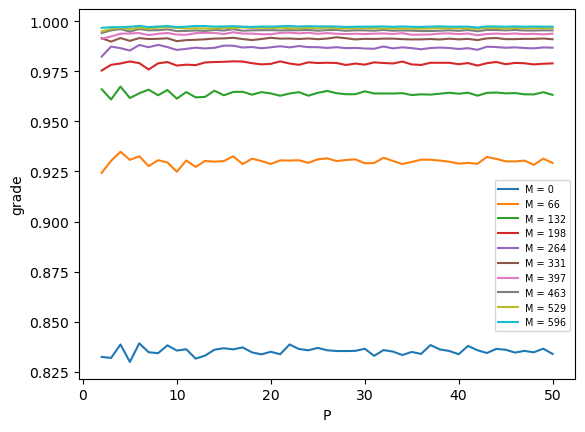

ValueError: left cannot be >= right

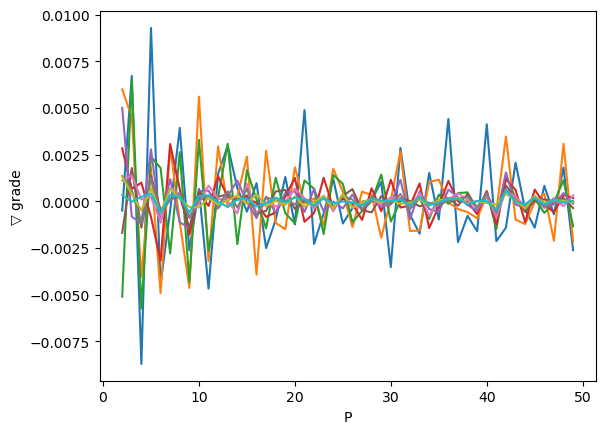

In [40]:
def prime_der(ys: np.ndarray):
    return [ys[i+1] - ys[i] for i in range(len(ys)-1)]

m_stepper = np.linspace(0, ysfiltered.shape[1]-1, 10, dtype=int)
for m in m_stepper:
    plt.plot(ps, ysfiltered[:, m], label="M = " + str(m))
plt.legend(bbox_to_anchor=(0.5, 0.05, 0.5, 0.5), fontsize='x-small')
plt.xlabel("P")
plt.ylabel("grade")
plt.savefig('./data/plots/exp1.3.M_section.P_2_to_' + str(Pmax) + '.png',dpi = 500)
plt.show()

for m in m_stepper:
    plt.plot(ps[:-1], prime_der(ysfiltered[:, m]), label="M = " + str(m))
plt.xlabel("P")
plt.ylabel("▽ grade")
plt.subplots_adjust(left=0.15)
plt.legend(bbox_to_anchor=(0.5, 0.5, 0.5, 0.5), fontsize='x-small')
plt.savefig('./data/plots/exp1.3.M_section_prime.P_2_to_' + str(Pmax) + '.png',dpi = 500)
plt.show()


# EXPERIMENT II
### Multivariate Gaussian distribution's parameters estimation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Real Mean:
 10
Real Covariance:
 3
--------------------
MCS
Estimated means: 
	 9.983831848218614
Estimated covariance: 
	 3.3792315642838067
--------------------
LHS
Estimated means: 
	 9.997560499533371
Estimated covariance: 
	 3.0317302981252308


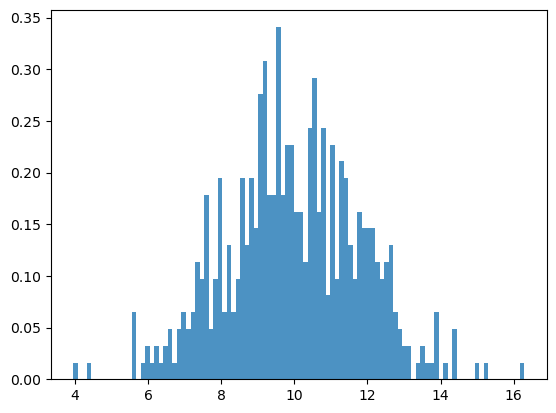

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


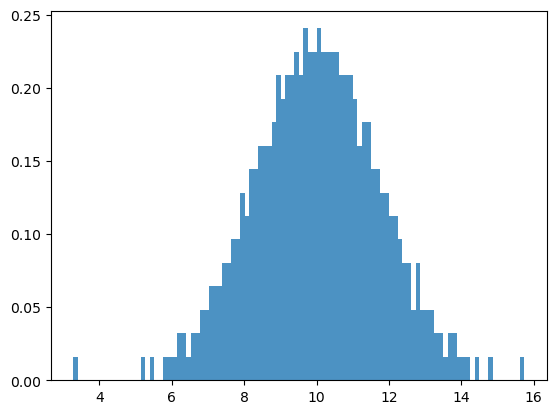

In [11]:
from scipy.stats import norm


N = 500
ssmc = np.random.rand(N)
sslhs = LHS.random(N)[:, 0]
mean = 10
variance = 3
vecppf = np.vectorize(lambda x: norm.ppf(x, loc=mean, scale=np.sqrt(variance)))
gauss_mc = vecppf(ssmc)
gauss_lhs = vecppf(sslhs)



print("Real Mean:\n", mean)
print("Real Covariance:\n", variance)
print("-"*20)
print("MCS")
print("Estimated means: \n\t", np.mean(gauss_mc))
print("Estimated covariance: \n\t", np.var(gauss_mc))
print("-"*20)
print("LHS")
print("Estimated means: \n\t", np.mean(gauss_lhs))
print("Estimated covariance: \n\t", np.var(gauss_lhs))


# plt.scatter(xs, gauss, s=.1)
# plt.show()
plt.hist(gauss_mc, density=True, bins=100, histtype='stepfilled', alpha=0.8)
plt.legend(loc='best', frameon=False)
plt.show()

plt.hist(gauss_lhs, density=True, bins=100, histtype='stepfilled', alpha=.8)
plt.legend(loc='best', frameon=False)
plt.show()

### "I'm a failure" block below

In [9]:

def build_gaussian_pdf(mean:np.ndarray, cov:np.ndarray):
    mean = np.array(mean)
    cov = np.array(cov)
    n = mean.shape[0]
    denominator = np.sqrt((2 * np.pi) ** n * np.linalg.det(cov))
    def pdf(x:np.ndarray):
        diff = x - mean
        exponent = -0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff)
        return np.exp(exponent) / denominator
    return pdf

N, P = 10, 1
mean_a, mean_b = 1/4, 3/4   # first quartile, third quartile

means = np.random.uniform(mean_a, mean_b, P)
A = np.random.rand(P, P)
cov_matrix = np.dot(A, A.T)

# Generate samples from the multivariate Gaussian distribution
samples = np.random.multivariate_normal(means, cov_matrix, N)
# Estimate the mean vector from the samples
estimated_mean = np.mean(samples, axis=0)

# Estimate the covariance matrix from the samples
estimated_cov = np.cov(samples, rowvar=False)


print("Real Mean:\n", means)
print("Real Covariance:\n", cov_matrix)
print("-"*20)
print("Estimated Mean:\n", estimated_mean)
print("Estimated Covariance Matrix:\n", estimated_cov)

print("\n", "#"*20, "\n")

pdf1 = build_gaussian_pdf(means, cov_matrix)
exp2ss = LHSampler(d=P).random(N)
exp2sampled = pdf1(exp2ss)

est_mean1 = np.mean(exp2sampled, axis=0)
est_cov1 = np.cov(exp2sampled, rowvar=False)

print("Real Mean:\n", means)
print("Real Covariance:\n", cov_matrix)
print("-"*20)
print("Estimated means: \n\t", est_mean1)
print("Estimated covariance: \n\t", est_cov1)



Real Mean:
 [0.45393952]
Real Covariance:
 [[0.37057712]]
--------------------
Estimated Mean:
 [0.51487127]
Estimated Covariance Matrix:
 0.46538443157078685

 #################### 



ValueError: shapes (1,10) and (1,1) not aligned: 10 (dim 1) != 1 (dim 0)

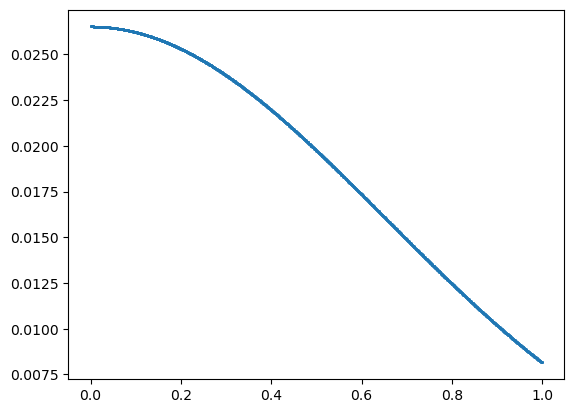

In [11]:
from scipy.stats import norm

def multivariate_gaussian(mean, cov, n_samples):
    """
    Generate samples from a multivariate normal distribution.

    Parameters:
    mean (array-like): Mean vector of the distribution.
    cov (array-like): Covariance matrix of the distribution.
    n_samples (int): Number of samples to generate.

    Returns:
    samples (ndarray): Generated samples of shape (n_samples, n_features).
    """
    mean = np.array(mean)
    cov = np.array(cov)
    n_features = mean.shape[0]

    # L = np.linalg.svd(cov)
    L = np.linalg.cholesky(cov)

    # Step 2: Generate samples from a standard normal distribution
    standard_normal_samples = np.random.randn(n_samples, n_features)

    # Step 3: Transform the standard normal samples
    samples = mean + standard_normal_samples @ L.T

    return samples

meantest = [0, 0]
covtest = [[1, 8], 
           [8, 100]]

samplex, sampley = multivariate_gaussian(meantest, covtest, 10000).T
plt.scatter(samplex, sampley, s=1)
plt.show()

# xs = np.linspace(0, 1, 1000)
# plt.plot(xs, norm.pdf(xs, loc=0.5, scale=0.1))
# plt.show()

In [ ]:
from randomgen.wrapper import UserBitGenerator

class pippolhs:
    def __init__(self, sampler, N):
        self.sampler = sampler
        self.N = N
    
    def random_raw(self, voidp):
        return sampler.random(self.N).tolist()
    
UserBitGenerator(pippolhs(LHSampler(d=2), 10).random_raw)
# UserBitGenerator.random_raw(1, (10, 2))


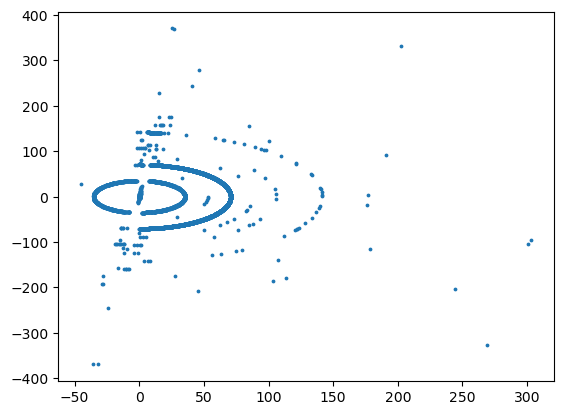

In [71]:
from scipy.optimize import root, fsolve

initial_guess = [0.5] * 2

meantest = [0, 0]
covtest = [[1, 8], 
           [8, 100]]

def build_randomizer_system(mean:np.ndarray, sigma:np.ndarray):
    M = np.array(mean)
    P = len(M)
    pdf = build_gaussian_pdf(mean, sigma)
    peak = pdf(M)

    def L(t:float, omegas:np.ndarray):
        omegas = np.array(omegas)
        D = [ 
            np.prod(
                np.sin([
                    omegas[j] for j in range(0, i)
                ]
            )) * np.cos(omegas[i]) for i in range(len(omegas))
        ]
        D.append(np.prod(np.sin(omegas)))
        D = np.array(D)
        return M + t * D

    def magic(Xt, *args):
        X, t = Xt[0:-1], Xt[-1]
        Z, omegas = args
        return [
            pdf(X) - Z,
            *(L(t, omegas) - X)
        ]
    
    def randomizer(N:int):
        samples = np.zeros((N, P))
        for i in range(N):
            # Z = np.random.uniform(0, peak)
            Z = np.random.normal(loc=(peak/2), scale=1/8)
            omegas = np.random.uniform(0, 2*np.pi, P - 1)
            sol = fsolve(magic, (0, 0, 0), args=(Z, omegas))[:-1]
            samples[i] = sol
        return samples

    return randomizer

myrand = build_randomizer_system(meantest, covtest)

rrr = myrand(10000)
plt.scatter(rrr[:, 0], rrr[:, 1], s=3)


In [6]:
# importing sympy and its friends
import sympy as sm
from sympy import symbols, Matrix, Transpose, init_printing
from sympy.printing.mathml import print_mathml

meantest = [0, 0]
covtest = [[1, 8], 
           [8, 100]]

def build_gaussian_pdf_for_sympy(mean:np.ndarray, cov:np.ndarray):
    mean = np.array(mean)
    cov = np.array(cov)
    n = len(mean)
    denominator = np.sqrt((2 * np.pi) ** n * np.linalg.det(cov)).tolist()
    def pdf(X):
        diff = X - mean.tolist()
        exponent = -0.5 * ((Transpose(diff) * np.linalg.inv(cov).tolist()) * diff)
        return (np.exp(1)**(exponent)) / denominator
    return pdf

# define symbols
X = symbols('x1,x2', real=True)

# solve the system of equations for [a,b,c,d]
print(sm.solve(build_gaussian_pdf_for_sympy(meantest, covtest)(X), X))




TypeError: unsupported operand type(s) for -: 'tuple' and 'list'